# Chapter 17 – Autoencoders, GANs, and Diffusion Models

This notebook contains all the sample code and solutions to the exercises in chapter 17.

## Setup
This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Warning: the latest TensorFlow versions are based on Keras 3. For chapters 10-15, it wasn't too hard to update the code to support Keras 3, but unfortunately it's much harder for this chapter, in particular adding custom losses using the functional API is not implemented yet. So for this chapter I've had to revert to Keras 2. To do that, I set the TF_USE_LEGACY_KERAS environment variable to "1" and import the tf_keras package. This ensures that tf.keras points to tf_keras, which is Keras 2.*.

In [3]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1" 

import tf_keras

ModuleNotFoundError: No module named 'tf_keras'

And TensorFlow ≥ 2.8:

In [4]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the ```images/generative``` folder (if it doesn't already exist), and define the ```save_fig()``` function which is used through this notebook to save the figures in high-res for the book:

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [7]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

## Performing PCA with an Undercomplete Linear Autoencoder
Let's build the Autoencoder...

In [8]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

Now let's generate the same 3D dataset as we used in Chapter 8:

In [9]:
# extra code – builds the same 3D dataset as in Chapter 8

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [10]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 2ms/step


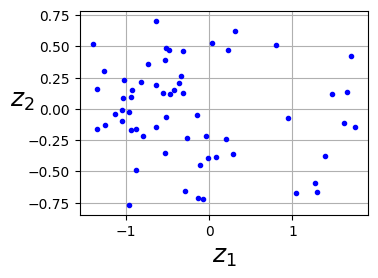

In [11]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

## Stacked Autoencoders
### Implementing a Stacked Autoencoder Using Keras
Let's load the fashion MNIST dataset, scale it, and split it into a training set, a validation set, and a test set:

In [12]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Let's build and train a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [13]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")                   
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0244 - val_loss: 0.0188
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0174 - val_loss: 0.0170
Epoch 3/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0158 - val_loss: 0.0155
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0140 - val_loss: 0.0139
Epoch 7/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0137 - val_loss: 0.0140
Epoch 8/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0136 - val_loss: 0.0137
Epoch 9/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0134 - val_loss: 0.0137
Epoch 10/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.013